___Assymetry Test___

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math

Angle of the principal axis: 1.45 radians


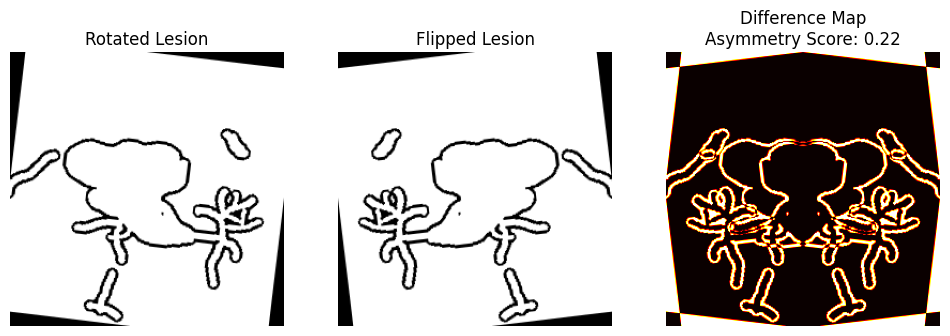

Asymmetry Index: 0.22


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math

def preprocess_image(image_path):
    """Preprocesses the image: resize, denoise, enhance contrast, and threshold."""
    # Load and resize image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (256, 256))  # Standardize size

    # Convert to grayscale
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    # Apply adaptive thresholding for better segmentation
    thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 5, 5)
    return thresh

def detect_asymmetry_with_pca(image_path):
    """Detects asymmetry using PCA for axis detection."""
    # Preprocess the image
    binary_mask = preprocess_image(image_path)

    # Extract coordinates of the lesion
    coordinates = np.column_stack(np.where(binary_mask > 0))

    if coordinates.shape[0] == 0:
        print("No lesion detected")
        return None

    # Perform PCA to find principal axes
    pca = PCA(n_components=2)
    pca.fit(coordinates)
    principal_axes = pca.components_

    # Compute angle of the principal axis
    main_axis = principal_axes[0]
    angle = math.atan2(main_axis[1], main_axis[0])
    print(f"Angle of the principal axis: {angle:.2f} radians")

    # Rotate the lesion mask to align with the principal axis
    center = (binary_mask.shape[1] // 2, binary_mask.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle * 180 / np.pi, 1)  # Convert angle to degrees
    rotated_mask = cv2.warpAffine(binary_mask, rotation_matrix, binary_mask.shape[::-1])

    # Flip the rotated mask
    flipped_mask = cv2.flip(rotated_mask, 1)

    # Compute asymmetry score (difference between original and flipped)
    diff = cv2.absdiff(rotated_mask, flipped_mask)
    asymmetry_score = np.sum(diff) / np.sum(rotated_mask) if np.sum(rotated_mask) > 0 else 0

    # Visualize results
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(rotated_mask, cmap='gray')
    ax[0].set_title("Rotated Lesion")
    ax[1].imshow(flipped_mask, cmap='gray')
    ax[1].set_title("Flipped Lesion")
    ax[2].imshow(diff, cmap='hot')
    ax[2].set_title(f"Difference Map\nAsymmetry Score: {asymmetry_score:.2f}")

    for a in ax:
        a.axis('off')
    plt.show()

    return asymmetry_score

# Example Usage
image_path = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_256_394_449_mask.png"
asymmetry_value = detect_asymmetry_with_pca(image_path)
print(f"Asymmetry Index: {asymmetry_value:.2f}" if asymmetry_value is not None else "Lesion not detected.")

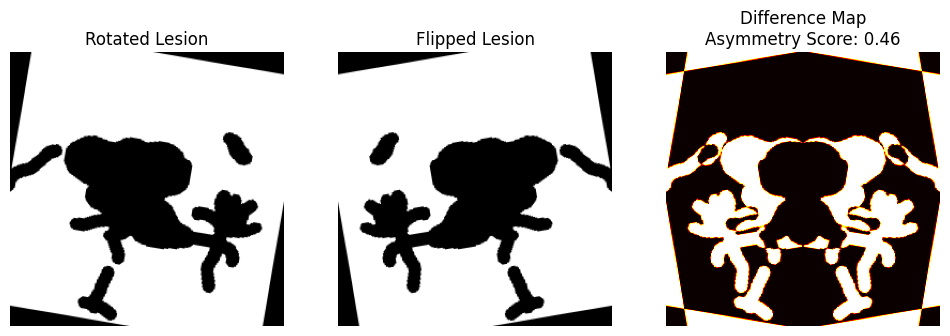

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math

def preprocess_image(image_path):
    """Preprocesses the image: resize, denoise, enhance contrast, and threshold."""
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (256, 256))  # Standardize size
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 5, 5)
    return thresh

def get_largest_component(binary_image):
    """Keeps only the largest connected component."""
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    if num_labels <= 1:
        return binary_image
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    largest_component = (labels == largest_label).astype(np.uint8) * 255
    return largest_component

def detect_asymmetry_with_preprocessing(image_path):
    binary_mask = preprocess_image(image_path)
    binary_mask = get_largest_component(binary_mask)

    coordinates = np.column_stack(np.where(binary_mask > 0))
    if coordinates.shape[0] == 0:
        print("No lesion detected")
        return None

    pca = PCA(n_components=2)
    pca.fit(coordinates)
    main_axis = pca.components_[0]
    angle = math.atan2(main_axis[1], main_axis[0])
    center = (binary_mask.shape[1] // 2, binary_mask.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle * 180 / np.pi, 1)
    rotated_mask = cv2.warpAffine(binary_mask, rotation_matrix, binary_mask.shape[::-1])
    flipped_mask = cv2.flip(rotated_mask, 1)

    diff = cv2.absdiff(rotated_mask, flipped_mask)
    asymmetry_score = np.sum(diff) / np.sum(rotated_mask) if np.sum(rotated_mask) > 0 else 0

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(rotated_mask, cmap='gray')
    ax[0].set_title("Rotated Lesion")
    ax[1].imshow(flipped_mask, cmap='gray')
    ax[1].set_title("Flipped Lesion")
    ax[2].imshow(diff, cmap='hot')
    ax[2].set_title(f"Difference Map\nAsymmetry Score: {asymmetry_score:.2f}")
    for a in ax: a.axis('off')
    plt.show()

    return asymmetry_score

asym_score = detect_asymmetry_with_preprocessing(r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_256_394_449_mask.png")


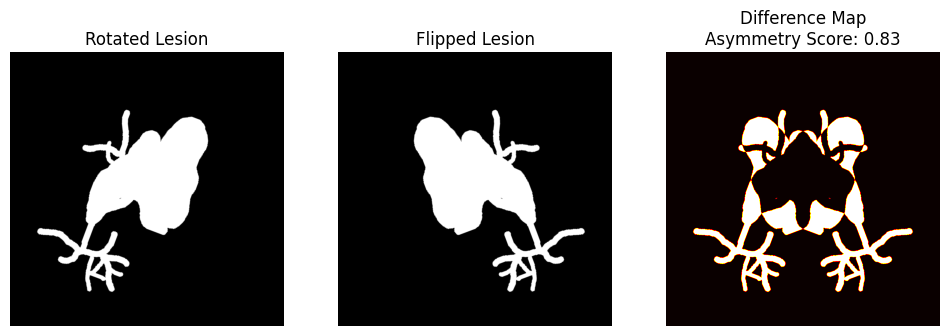

In [6]:
def load_binary_mask(image_path):
    """Loads an existing binary mask image as-is (no preprocessing)."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return binary

def get_largest_component(binary_image):
    """Keeps only the largest connected component."""
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    if num_labels <= 1:
        return binary_image
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    largest_component = (labels == largest_label).astype(np.uint8) * 255
    return largest_component

def detect_asymmetry_from_binary(image_path):
    binary_mask = load_binary_mask(image_path)
    binary_mask = get_largest_component(binary_mask)

    coordinates = np.column_stack(np.where(binary_mask > 0))
    if coordinates.shape[0] == 0:
        print("No lesion detected")
        return None

    pca = PCA(n_components=2)
    pca.fit(coordinates)
    main_axis = pca.components_[0]
    angle = math.atan2(main_axis[1], main_axis[0])
    center = (binary_mask.shape[1] // 2, binary_mask.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle * 180 / np.pi, 1)
    rotated_mask = cv2.warpAffine(binary_mask, rotation_matrix, binary_mask.shape[::-1])
    flipped_mask = cv2.flip(rotated_mask, 1)

    diff = cv2.absdiff(rotated_mask, flipped_mask)
    asymmetry_score = np.sum(diff) / np.sum(rotated_mask) if np.sum(rotated_mask) > 0 else 0

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(rotated_mask, cmap='gray')
    ax[0].set_title("Rotated Lesion")
    ax[1].imshow(flipped_mask, cmap='gray')
    ax[1].set_title("Flipped Lesion")
    ax[2].imshow(diff, cmap='hot')
    ax[2].set_title(f"Difference Map\nAsymmetry Score: {asymmetry_score:.2f}")
    for a in ax: a.axis('off')
    plt.show()

    return asymmetry_score

asym_score = detect_asymmetry_from_binary(r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_256_394_449_mask.png")
# "C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_273_421_905_mask.png"
# "C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_256_394_449_mask.png"
# C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_213_328_117_mask.png
# "C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_256_394_449_mask.png"

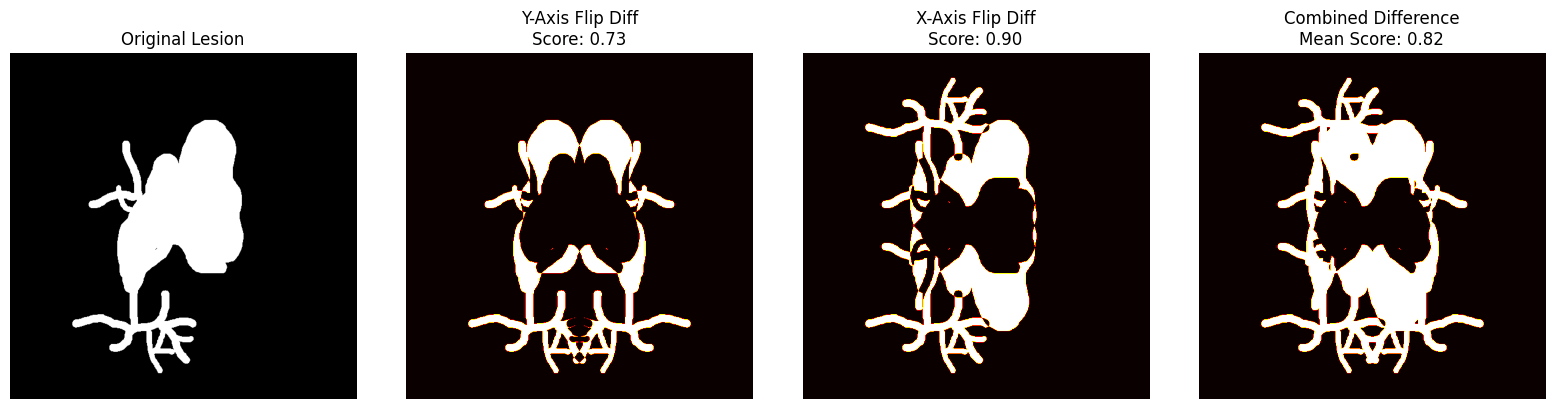

In [9]:
def load_binary_mask(image_path):
    """Loads an existing binary mask image as-is (no preprocessing)."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return binary

def get_largest_component(binary_image):
    """Keeps only the largest connected component."""
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    if num_labels <= 1:
        return binary_image
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    largest_component = (labels == largest_label).astype(np.uint8) * 255
    return largest_component

def center_crop(image):
    """Ensure image has even dimensions to allow perfect flipping."""
    h, w = image.shape
    if h % 2 != 0:
        image = image[:-1, :]
    if w % 2 != 0:
        image = image[:, :-1]
    return image

def detect_asymmetry_from_flips(image_path):
    binary_mask = load_binary_mask(image_path)
    binary_mask = get_largest_component(binary_mask)
    binary_mask = center_crop(binary_mask)

    # Flip over Y axis (vertical flip — mirror left/right)
    flip_y = cv2.flip(binary_mask, 1)

    # Flip over X axis (horizontal flip — mirror top/bottom)
    flip_x = cv2.flip(binary_mask, 0)

    # Calculate differences
    diff_y = cv2.absdiff(binary_mask, flip_y)
    diff_x = cv2.absdiff(binary_mask, flip_x)

    # Normalize asymmetry scores
    total_area = np.sum(binary_mask) + 1e-5
    score_y = np.sum(diff_y) / total_area
    score_x = np.sum(diff_x) / total_area

    mean_score = (score_y + score_x) / 2

    # Visualization
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(binary_mask, cmap='gray')
    ax[0].set_title("Original Lesion")
    ax[1].imshow(diff_y, cmap='hot')
    ax[1].set_title(f"Y-Axis Flip Diff\nScore: {score_y:.2f}")
    ax[2].imshow(diff_x, cmap='hot')
    ax[2].set_title(f"X-Axis Flip Diff\nScore: {score_x:.2f}")
    ax[3].imshow((diff_y + diff_x) // 2, cmap='hot')
    ax[3].set_title(f"Combined Difference\nMean Score: {mean_score:.2f}")
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    return mean_score

# Example usage
asym_score = detect_asymmetry_from_flips(
    r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_256_394_449_mask.png")